In [1]:
import torch
import os
import json
import tqdm
import collections
import random
import matplotlib.pyplot as plt
import numpy as np
import sklearn.model_selection

According to Kohonen, we can do about 50 datapoints per node. For 3.5k that means maybe 60-80 nodes.
I want a 5x4 resolution for display reasons, so maybe 10x8 nodes?

In [2]:
fnames = os.listdir("data")
fields = ['name','smiles','notes']
molecules = []
for fname in tqdm.tqdm(fnames):
    with open(os.path.join("data",fname)) as f:
        mol = json.load(f)
        data = {k:mol[k] for k in fields}
        # Check that the molecule has all the fields of interest
        if all(data.values()):
            molecules.append(data)

# Have to de-dupe the notes for each molecule.
for mol in molecules:
    mol["notes"] = set(mol["notes"])
    
print(f"Found {len(molecules)} molecules.")
molecules[:3]

100%|███████████████████████████████████| 19194/19194 [00:02<00:00, 6956.84it/s]

Found 3440 molecules.


[{'name': 'amyl butyrate',
  'smiles': 'CCCCCOC(=O)CCC',
  'notes': {'banana', 'cherry', 'fruity', 'pineapple', 'sweet', 'tropical'}},
 {'name': 'para-anisyl phenyl acetate',
  'smiles': 'COC1=CC=C(C=C1)COC(=O)CC2=CC=CC=C2',
  'notes': {'anise', 'balsamic', 'honey', 'woody'}},
 {'name': 'dihydrofarnesol',
  'smiles': 'CC(CC/C=C(\\C)/CCC=C(C)C)CCO',
  'notes': {'cyclamen', 'floral', 'metallic'}}]

In [3]:
all_notes = collections.Counter()
for mol in molecules:
    all_notes.update(mol["notes"])
print(f"Found {len(all_notes)} unique notes.")
print("Most common:")
print(all_notes.most_common(5))

Found 502 unique notes.
Most common:
[('fruity', 1060), ('green', 967), ('sweet', 884), ('floral', 706), ('woody', 558)]


In [4]:
all_notes_list = list(all_notes.keys())

def multi_hot(notes):
    indices = torch.tensor([all_notes_list.index(n) for n in notes])
    if len(indices) == 0:
        # Occurs when the notes in the pair were removed due to infrequency.
        raise AttributeError("Found no valid notes.")
    one_hots = torch.nn.functional.one_hot(indices, len(all_notes))
    return one_hots.sum(dim=0).float()

for mol in molecules:
    mol["encoding"] = multi_hot(mol["notes"])

print(molecules[0])

{'name': 'amyl butyrate', 'smiles': 'CCCCCOC(=O)CCC', 'notes': {'cherry', 'tropical', 'pineapple', 'fruity', 'sweet', 'banana'}, 'encoding': tensor([1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,

In [341]:
def flatten(mtrx):
    return mtrx.reshape((mtrx.shape[0]*mtrx.shape[1],-1)).squeeze()

def get_idx_grid(width,height,step):
    x_idx, y_idx = torch.meshgrid(torch.arange(start=0,end=width,step=step), torch.arange(start=0,end=height,step=step), indexing='ij')
    grid_idx = torch.stack([x_idx,y_idx],dim=-1)
    return flatten(grid_idx)
    
class SOM(object):
    def __init__(self,width,height,gauss=10,decay=.99,use_onehot=True):
        if use_onehot:
            # Select a random index to use as the hot element.
            idxs = torch.randint(low=0,high=len(all_notes),size=(width,height))
            # Convert to one hot of shape.
            self.vectors = torch.nn.functional.one_hot(idxs,num_classes=len(all_notes)).float()
        else:
            self.vectors = torch.rand(size=(width,height,len(all_notes))).float()
        
        self.gauss = gauss
        self.decay = decay

        self.vectors = flatten(self.vectors)
        self.map_idx = get_idx_grid(width,height,1)

    def do_decay(self):
        self.gauss *= self.decay

    def get_activations(self,encoding):
        # Activation is 1 / Euclidian(vectors, encoding).
        # The closer a vector is to the encoding, the higher the activation.
        return 1/(self.vectors-encoding).square().sum(dim=-1).sqrt()

    def get_enc_dists(self,encoding):
        # Activation is 1 / Euclidian(vectors, encoding).
        # The closer a vector is to the encoding, the higher the activation.
        return (self.vectors-encoding).square().sum(dim=-1).sqrt()

    def get_bmu(self,encoding):
        actvtn = self.get_activations(encoding)
        # Especially at the beginning of training, there may be a larger amount
        # of vectors that are equidistant to the encoding. 
        bmu_idxs = (actvtn==torch.max(actvtn)).nonzero()
        # In order to prevent embedding collapse, we select one randomly as the bmu.
        selected = np.random.randint(low=0,high=len(bmu_idxs))
        return bmu_idxs[selected]

    def mean_encoding_by_bmu(self,encodings,bmus):
        # https://stackoverflow.com/questions/56154604/groupby-aggregate-mean-in-pytorch/56155805#56155805
        M = torch.zeros(len(self.vectors), len(encodings))
        M[bmus, torch.arange(len(encodings))] = 1
        M = torch.nn.functional.normalize(M, p=1, dim=1)
        return torch.mm(M, encodings)

    def get_distances(self):
        # Distance from each node to every other node
        xy_dist = self.map_idx.unsqueeze(0) - self.map_idx.unsqueeze(1)
        return torch.sqrt(torch.sum(torch.square(xy_dist),dim=-1))

    def get_intra_vector_dist_range(self):
        xy_dist = self.vectors.unsqueeze(0) - self.vectors.unsqueeze(1)
        dists = torch.sqrt(torch.sum(torch.square(xy_dist),dim=-1))
        # We want to get the minimum distance from a vector to any OTHER vector,
        # so we need to ignore the 0 distances (which are from a vector to itself).
        return torch.min(dists[dists>0]), torch.max(dists)
    
    def get_intra_vector_activation_range(self):
        xy_dist = self.vectors.unsqueeze(0) - self.vectors.unsqueeze(1)
        dists = torch.sqrt(torch.sum(torch.square(xy_dist),dim=-1))
        # We want to get the minimum distance from a vector to any OTHER vector,
        # so we need to ignore the 0 distances (which are from a vector to itself).
        # Activations are just inverse of distance.
        return 1/torch.max(dists), 1/torch.min(dists[dists>0])

    def update_factor(self):
        dists = self.get_distances()
        return torch.exp(torch.neg(torch.div(dists.square(), 2*self.gauss**2)))

    def batch_sum_encodings(self,bmus,encodings):
        # Although this is referred to as h_ji in the paper
        # it is symmetric (so h[j][i] == h[i][j])
        h_ij = self.update_factor()
        x_mj = self.mean_encoding_by_bmu(encodings,bmus)
        
        bmu_count_by_idx = torch.bincount(bmus, minlength=len(self.map_idx))
        # Unsqueeze the first dimension of the counts so that the update factor
        # for i to j is weighted based on occurences of j.
        weighted_h_ji = bmu_count_by_idx.unsqueeze(0)*h_ij

        return torch.mm(weighted_h_ji, x_mj)/weighted_h_ji.sum(dim=-1,keepdim=True)

    def update_batch(self,encodings):
        # This step is not vectorized, but we could do a random partitioning or something above.
        bmus = torch.cat([self.get_bmu(e) for e in encodings])
        self.vectors = self.batch_sum_encodings(bmus,encodings)
        
def test():
    mm = SOM(3,2)
    encodings = torch.stack([mol["encoding"] for mol in molecules[:10]])
    mm.update_batch(encodings)
    

test()

In [342]:
class SOM__(object):
    def __init__(self,som):
        self.vectors = som.vectors
        self.map_idx = som.map_idx
        self.gauss = som.gauss

    def get_activations(self,encoding):
        # Activation is 1 / Euclidian(vectors, encoding).
        # The closer a vector is to the encoding, the higher the activation.
        return 1/(self.vectors-encoding).square().sum(dim=-1).sqrt()

    def get_bmu(self,encoding):
        actvtn = self.get_activations(encoding)
        # Especially at the beginning of training, there may be a larger amount
        # of vectors that are equidistant to the encoding. 
        bmu_idxs = (actvtn==torch.max(actvtn)).nonzero()
        # In order to prevent embedding collapse, we select one randomly as the bmu.
        selected = np.random.randint(low=0,high=len(bmu_idxs))
        return bmu_idxs[selected]

    def mean_encoding_by_bmu__(self,encodings,bmus):
        sum_mj = torch.zeros(self.vectors.shape)
        count_mj = torch.zeros(self.vectors.shape[0])
        for i, v_idx in enumerate(bmus):
            count_mj[v_idx] += 1
            sum_mj[v_idx] += encodings[i]

        x_mj = torch.zeros(self.vectors.shape)
        for i, sm in enumerate(sum_mj):
            if count_mj[i] > 0:
                x_mj[i] = sm / count_mj[i]
            else:
                x_mj[i] = torch.zeros(sm.shape)

        return x_mj

    def update_factor__(self):
        uf = torch.empty((len(self.map_idx),len(self.map_idx)))
        for i, p1 in enumerate(self.map_idx):
            for j, p2 in enumerate(self.map_idx):
                xy_dist = p1 - p2
                d = torch.sqrt(torch.sum(torch.square(xy_dist),dim=-1))
                uf[i][j] = torch.exp(torch.neg(torch.div(d.square(), 2*self.gauss**2)))
        return uf

    def batch_sum_encodings__(self,bmus,encodings):
        h_ij = self.update_factor__()
        x_mj = self.mean_encoding_by_bmu__(encodings,bmus)

        bmu_count_by_idx = torch.zeros(self.vectors.shape[0])
        for i, v_idx in enumerate(bmus):
            bmu_count_by_idx[v_idx] += 1

        bse = torch.zeros(self.vectors.shape)
        for i in range(len(h_ij)):
            denom = torch.zeros(bmu_count_by_idx.shape)
            for j in range(len(h_ij)):
                bse[i] += x_mj[j] * h_ij[i][j] * bmu_count_by_idx[j]
                denom[i] += h_ij[i][j] * bmu_count_by_idx[j]
            
            if denom[i] > 0:
                bse[i] = bse[i] / denom[i]
            else:
                bse[i] = torch.zeros(bse[i].shape)

        return bse
            
        
def test():
    mm = SOM(3,2)
    mm__ = SOM__(mm)
    encodings = torch.stack([mol["encoding"] for mol in molecules[:10]])
    bmus = torch.cat([mm.get_bmu(e) for e in encodings])

    assert torch.all(mm.vectors==mm__.vectors)

    def test_update_factor():
        nonlocal mm, mm__
        h_ij = mm.update_factor()
        h_ij__ = mm__.update_factor__()
        assert torch.isclose(h_ij,h_ij__).all()

    def test_update_factor_symmetric():
        nonlocal mm, mm__, bmus
        h_ij__ = mm__.update_factor__()
        for i in range(len(h_ij__)):
            for j in range(len(h_ij__)):
                assert h_ij__[i][j] == h_ij__[j][i]
            
    def test_mean_encoding_by_bmu():
        nonlocal mm, mm__, bmus, encodings
        x_mj = mm.mean_encoding_by_bmu(encodings,bmus)
        x_mj__ = mm__.mean_encoding_by_bmu__(encodings,bmus)
        assert torch.isclose(x_mj,x_mj__).all()

    def test_batch_sum_encodings():
        nonlocal mm, mm__, bmus, encodings
        # bmus are selected randomly, so we inject them here
        bse = mm.batch_sum_encodings(bmus,encodings)
        bse__ = mm__.batch_sum_encodings__(bmus,encodings)
        assert torch.isclose(bse,bse__).all()
    
    test_update_factor()
    test_update_factor_symmetric()
    test_mean_encoding_by_bmu()
    test_batch_sum_encodings()
    

test()

In [403]:
train_mols, test_mols = sklearn.model_selection.train_test_split(molecules)

def do_train(config,verbose=False):
    som = SOM(width=config["width"],
              height=config["height"],
              gauss=config["gauss"],
              decay=config["decay"],
              use_onehot=config["onehot"])
    
    encodings = torch.stack([mol["encoding"] for mol in molecules])
        
    for _ in tqdm.tqdm(range(config["batches"]),smoothing=0, disable=not verbose):
        som.update_batch(encodings)

    return som

w = 5
h = 4
som = do_train({'width': w, 'height': h, 'batches': 10,"gauss":1, "decay": .99, "onehot": True},verbose=True)
for n, f in all_notes.most_common(10):
    print(n,som.get_bmu(multi_hot([n])))
print()
for mol in molecules[:10]:
    print(mol["name"],som.get_bmu(mol["encoding"]))

activations = torch.stack([som.get_activations(enc) for enc in _encodings])
amin, amax = activations.min(), activations.max()

100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 11.35it/s]

fruity tensor([15])
green tensor([0])
sweet tensor([18])
floral tensor([12])
woody tensor([19])
herbal tensor([9])
fresh tensor([10])
fatty tensor([7])
waxy tensor([7])
spicy tensor([10])

amyl butyrate tensor([18])
para-anisyl phenyl acetate tensor([19])
dihydrofarnesol tensor([12])
(Z)-alpha-damascone tensor([12])
methyl phenyl acetate tensor([16])
dihydro-alpha-ionone tensor([16])
(S)-2-methyl butyraldehyde tensor([15])
allyl 10-undecenoate tensor([3])
saffron indenone tensor([9])
phenyl acetaldehyde dimethyl acetal tensor([8])


In [499]:
def plot(title,encoding,as_size,factor=1,thresh=1e-5,activations=None):
    bmu = som.get_bmu(encoding)
    if not torch.is_tensor(activations):
        activations = som.get_activations(encoding)

    act = (activations - amin) / (amax - amin)
    minv, maxv = act.min().numpy(), act.max().numpy()

    pos = som.map_idx.numpy()
    if as_size:
        # For very very small values, matplotlib will underflow and draw circles where it should draw tiny circles.
        act = torch.nn.functional.threshold(act,thresh,0)
        plt.scatter(pos[:,0],pos[:,1],s=factor*(act.numpy()**2))
    else:
        plt.scatter(pos[:,0],pos[:,1],c=factor*(act.numpy()**2))
        plt.set_cmap('PiYG_r')
        plt.colorbar()
        # cbar.lim(minv,maxv)

    plt.title(f"{title}\nBMU of {bmu.numpy()} w/ value = {act[bmu].item():.2f}. Range = ({minv:.2f}, {maxv:.2f})")



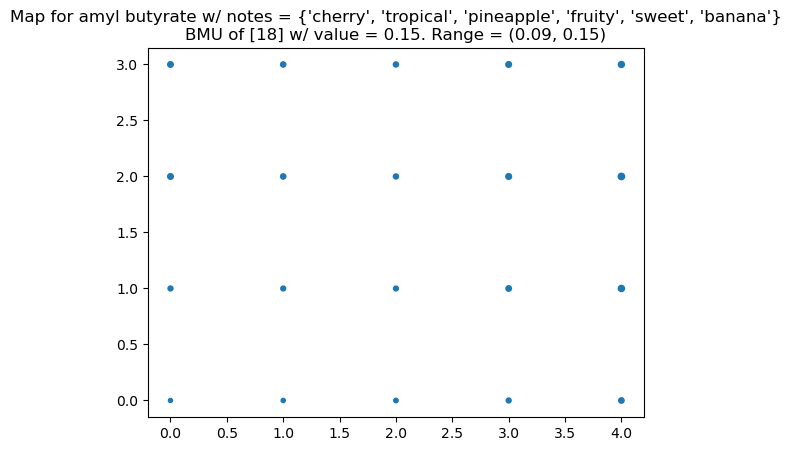

In [500]:
plot(f"Map for {molecules[0]['name']} w/ notes = {molecules[0]['notes']}",
     molecules[0]["encoding"],
     as_size=True,
     factor=1000)

plt.show()

In [559]:
def get_fine_act(step,activations,eps=1e-6):
    global w,h
    fine_grid = get_idx_grid(w,h,step)
    xy_dist = som.map_idx.unsqueeze(1) - fine_grid.unsqueeze(0)
    dist = torch.sqrt(torch.sum(torch.square(xy_dist),dim=-1))
    inverse_dist = 1 / (dist+eps)
    weight = inverse_dist / (inverse_dist.sum(dim=-1,keepdim=True))
    return fine_grid, torch.matmul(activations,weight)

# def test_fine_act(step,k=3):
#     global w,h, activations
#     fine_grid__ = get_idx_grid(w,h,step)
#     d = torch.zeros((len(fine_grid__),len(som.map_idx)))
#     for i,p1 in enumerate(fine_grid__):
#         for j,p2 in enumerate(som.map_idx):
#             xy_dist = p1 - p2
#             d[i][j] = torch.sqrt(torch.sum(torch.square(xy_dist),dim=-1))

#     closest_idx = (-d).topk(k).indices
#     ds = torch.gather(d,1,closest_idx)
    
#     print("D0",d[0])
#     print("CI0",closest_idx[0])
#     print("DS0",ds[0])
#     print(d.shape)
#     print(ds.shape)
#     # print(torch.topk(d,k=4,dim=-1))

def get_fine_range(step):
    global activations
    _, fine_act = get_fine_act(step,activations)
    return fine_act.min(), fine_act.max()
    

# test_fine_act(1)
fa = get_fine_act(.1,activations)
# print(fa[0].shape,fa[1].shape)
# print(get_fine_range(.1))

In [430]:
def test_summation():
    global w,h,activations
    fine_grid = get_idx_grid(w,h,1)
    factor = torch.eye(w*h)
    norm_f = factor/factor.sum(dim=-1,keepdim=True)
    fine_act = torch.matmul(activations,norm_f)
    assert torch.all(fine_act == activations)

test_summation()

80
80
tensor([[0.0000, 0.0000],
        [0.0000, 0.5000],
        [0.0000, 1.0000],
        [0.0000, 1.5000],
        [0.0000, 2.0000],
        [0.0000, 2.5000],
        [0.0000, 3.0000],
        [0.0000, 3.5000],
        [0.5000, 0.0000],
        [0.5000, 0.5000]])
tensor([3.9148e-01, 4.9046e-06, 4.2196e-01, 5.2635e-06, 4.4905e-01, 5.0618e-06,
        4.4583e-01, 3.8679e-06, 4.9018e-06, 5.1811e-06])


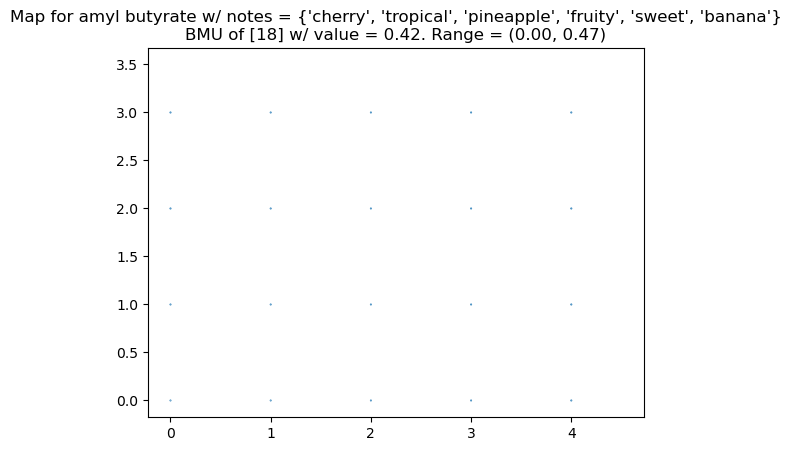

In [586]:
def plot_fine(title,encoding,as_size,step,factor=1,thresh=1e-5,activations=None):
    bmu = som.get_bmu(encoding)
    if not torch.is_tensor(activations):
        activations = som.get_activations(encoding)

    pos,activations = get_fine_act(step,activations)
    print(len(pos))
    print(len(activations))
    print(pos[:10])
    print(activations[:10])
    fmin,fmax = get_fine_range(step)
    act = (activations - fmin) / (fmax - fmin)
    minv, maxv = act.min().numpy(), act.max().numpy()
    print(activations.min(),activations.max())
    print(amin,amax)
    print(fmin,fmax)

    if as_size:
        # For very very small values, matplotlib will underflow and draw circles where it should draw tiny circles.
        act = torch.nn.functional.threshold(act,thresh,0)
        plt.scatter(pos[:,0],pos[:,1],s=factor*(act.numpy()**2))
    else:
        plt.scatter(pos[:,0],pos[:,1],c=factor*(act.numpy()**2))
        plt.set_cmap('PiYG_r')
        plt.colorbar()
        # cbar.lim(minv,maxv)

    plt.title(f"{title}\nBMU of {bmu.numpy()} w/ value = {act[bmu].item():.2f}. Range = ({minv:.2f}, {maxv:.2f})")

plot_fine(f"Map for {molecules[0]['name']} w/ notes = {molecules[0]['notes']}",
     molecules[0]["encoding"],
     as_size=True,
     step=.5,
     factor=100)

# plot_fine(f"Map for {molecules[0]['name']} w/ notes = {molecules[0]['notes']}",
#      molecules[0]["encoding"],
#      as_size=True,
#      step=1,
#      factor=10000)


plt.show()

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

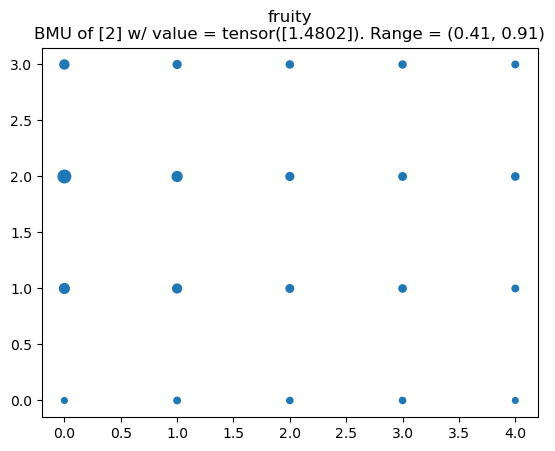

fruity tensor([2])


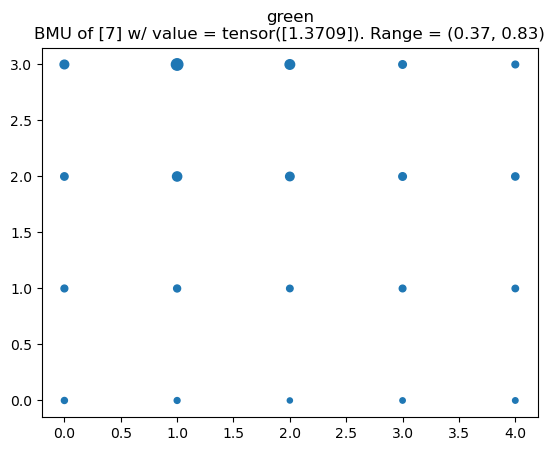

green tensor([7])


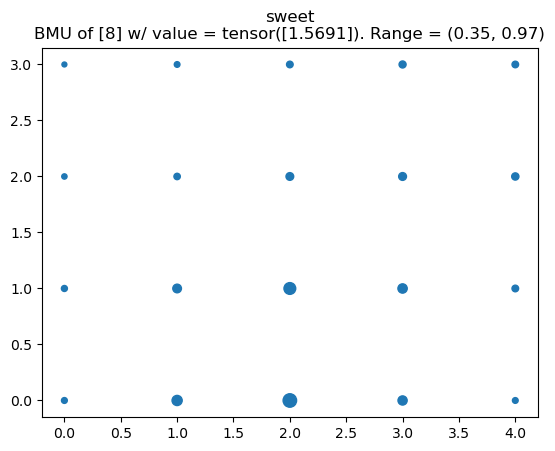

sweet tensor([8])


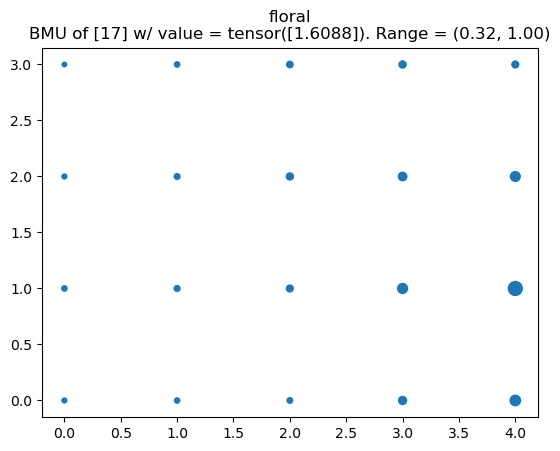

floral tensor([17])


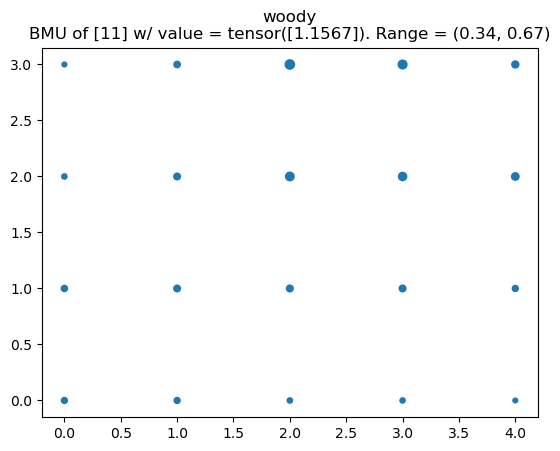

woody tensor([11])


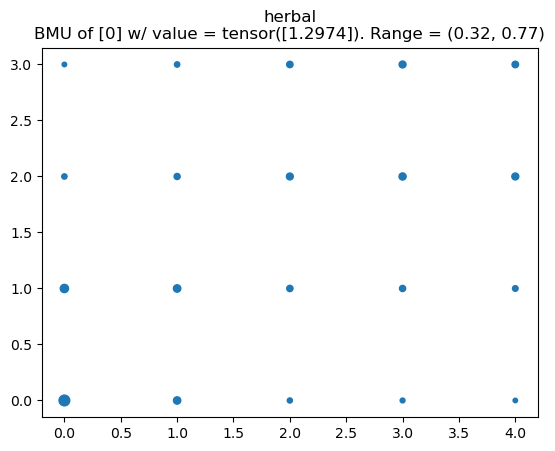

herbal tensor([0])


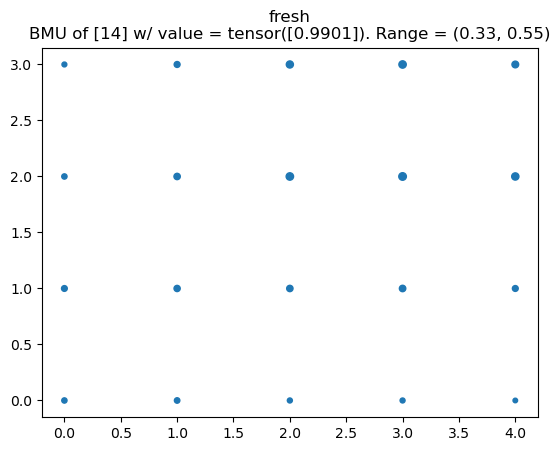

fresh tensor([14])


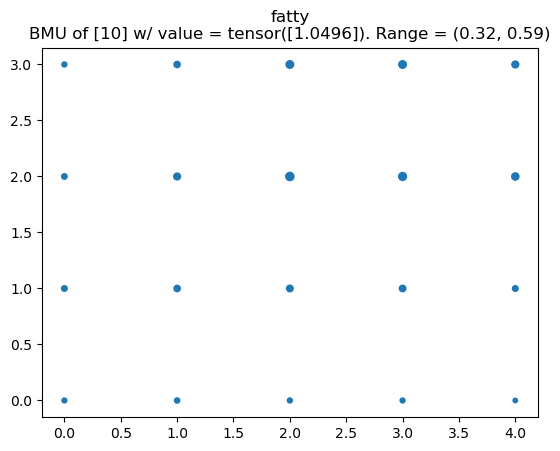

fatty tensor([10])


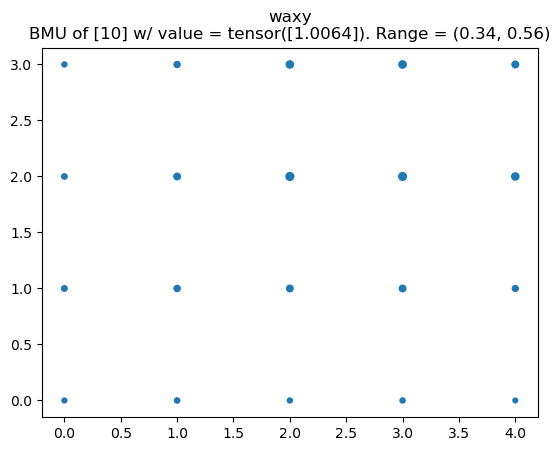

waxy tensor([10])


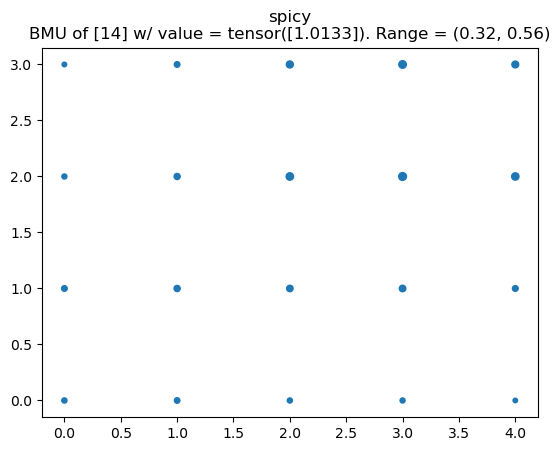

spicy tensor([14])


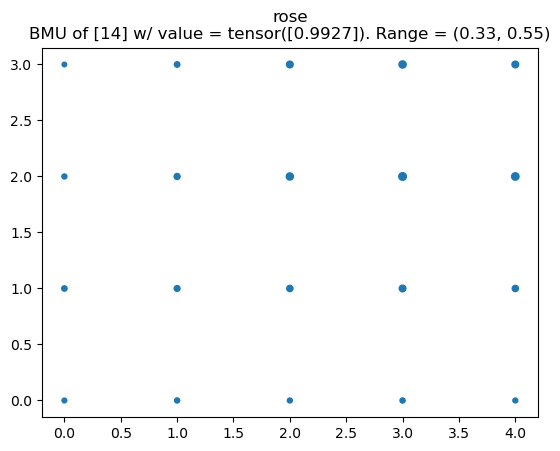

rose tensor([14])


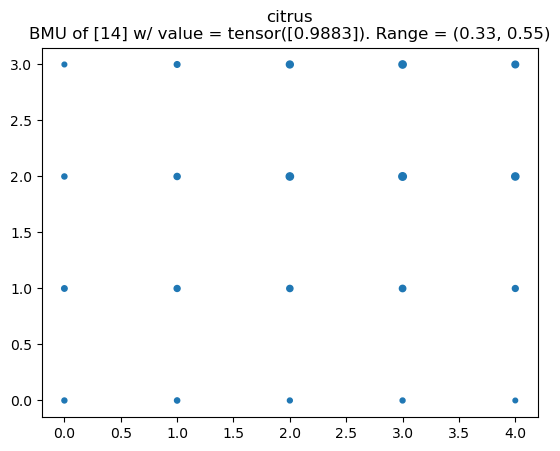

citrus tensor([14])


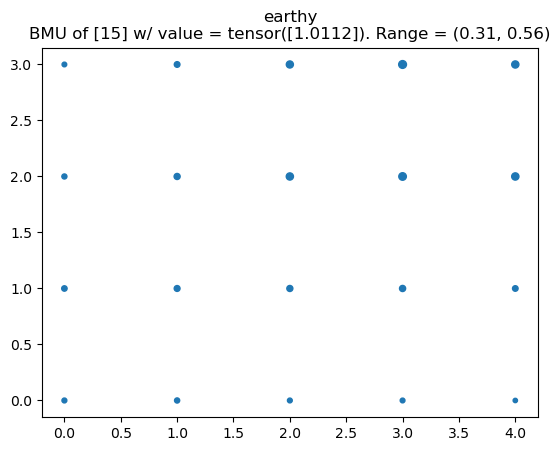

earthy tensor([15])


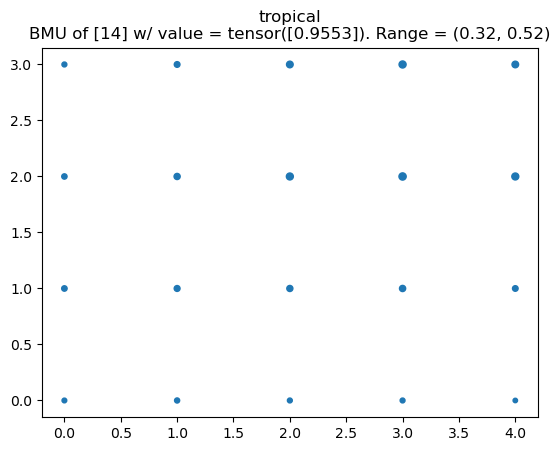

tropical tensor([14])


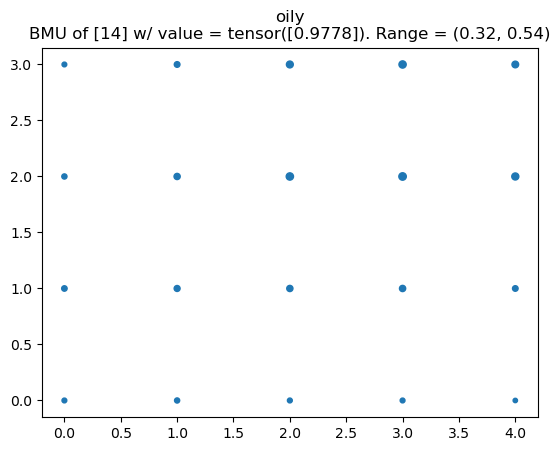

oily tensor([14])


In [319]:
for n, f in all_notes.most_common(15):
    plot(n,multi_hot([n]),as_size=True,thresh=1e-1,factor=100)
    plt.show()
    print(n,som.get_bmu(multi_hot([n])))

In [ ]:
plot(